In [14]:
import xlwings as xw
from pathlib import Path
import pandas as pd
import numpy as np
import time
from tqdm import trange

# ================== CONFIG ==================
RUN_CONFIG = {
    "n_runs": 1000,
    "crest_file": Path(r"E:\CREST Model\CREST_Demand_Model_v2.3.3.xlsm"),
    "output_dir": Path(
        r"E:\GitHubProjects\LV network\Input data\Hotwater"
    ),
    "output_csv_template": "crest_{scenario}_30min.csv",
    "main_sheet": "Main Sheet",
    "dwelling_sheet": "Dwelling",
    "output_sheet": "Results - disaggregated",
    "macro_name": "RunSimulationButton_Click",
    "we_wd_cell": "F7",
    "occupancy_cell": "B5",
    "scenarios": [
        {"name": "wd_occ5", "occupancy": 5, "we_wd": "wd"},
        {"name": "we_occ5", "occupancy": 5, "we_wd": "we"},
    ],
    "data_ranges": {
        "hotwater_L": "O7:O1446",
        "occupancy": "D7:D1446",
        "activity": "E7:E1446",
        "appliance_demand_W": "G7:G1446",
    },
    "resample_freq": "30min",
}
# ============================================

OUTPUT_DIR = RUN_CONFIG["output_dir"]
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

N_RUNS = RUN_CONFIG["n_runs"]
CREST_FILE = RUN_CONFIG["crest_file"]
MAIN_SHEET = RUN_CONFIG["main_sheet"]
DWELLING_SHEET = RUN_CONFIG["dwelling_sheet"]
OUTPUT_SHEET = RUN_CONFIG["output_sheet"]
MACRO_NAME = RUN_CONFIG["macro_name"]
WE_WD_CELL = RUN_CONFIG["we_wd_cell"]
OCCUPANCY_CELL = RUN_CONFIG["occupancy_cell"]
SCENARIOS = RUN_CONFIG["scenarios"]
OUTPUT_CSV_TEMPLATE = RUN_CONFIG["output_csv_template"]
DATA_RANGES = RUN_CONFIG["data_ranges"]
RESAMPLE_FREQ = RUN_CONFIG["resample_freq"]

EXPECTED_ROWS = 1440
MINUTE_INDEX = pd.date_range("00:00", periods=EXPECTED_ROWS, freq="min", name="time")


def resample_minutely(df_min: pd.DataFrame, freq: str) -> pd.DataFrame:
    resampled = pd.DataFrame(
        {
            "hotwater_L": df_min["hotwater_L"].resample(freq).sum(),
            "occupancy": df_min["occupancy"].resample(freq).mean(),
            "activity": df_min["activity"].resample(freq).mean(),
            "appliance_demand_W": df_min["appliance_demand_W"].resample(freq).mean(),
        }
    )
    resampled["occupancy"] = np.ceil(resampled["occupancy"]).astype(int)
    resampled["activity"] = np.ceil(resampled["activity"]).astype(int)
    return resampled


# ================== EXCEL APP ==================
app = xw.App(visible=False, add_book=False)
app.display_alerts = False
app.screen_updating = False

wb = app.books.open(CREST_FILE)

ws_main = wb.sheets[MAIN_SHEET]
ws_dwelling = wb.sheets[DWELLING_SHEET]
ws_out = wb.sheets[OUTPUT_SHEET]

run_macro = wb.macro(MACRO_NAME)

# ================== BATCH RUN ==================
for scenario in SCENARIOS:
    ws_dwelling[OCCUPANCY_CELL].value = scenario["occupancy"]
    ws_main[WE_WD_CELL].value = scenario["we_wd"]

    all_runs = []

    for i in trange(N_RUNS, desc=f"CREST {scenario['name']} simulations", unit="run"):
        # reset stop flag (safety)
        ws_main["J18"].value = ""

        # run CREST
        run_macro()

        # make sure Excel finishes
        app.calculate()
        time.sleep(0.2)

        # read output
        demand_data = {
            key: ws_out[cell_range].value for key, cell_range in DATA_RANGES.items()
        }

        df_min = pd.DataFrame(demand_data, index=MINUTE_INDEX).apply(
            pd.to_numeric, errors="coerce"
        )

        df_30min = resample_minutely(df_min, RESAMPLE_FREQ).add_prefix(f"run_{i}_")

        # store run
        all_runs.append(df_30min)

    # ================== COMBINE & SAVE ==================
    df = pd.concat(all_runs, axis=1)

    # optional: add time index (30-minute bins)
    df.index.name = "time"

    output_csv = OUTPUT_DIR / OUTPUT_CSV_TEMPLATE.format(scenario=scenario["name"])
    df.to_csv(output_csv)

    print(f"✅ CREST batch generation completed for {scenario['name']}")
    print(f"📄 Saved to: {output_csv}")

# ================== CLEANUP ==================
wb.close()
app.quit()


CREST simulations: 100%|██████████| 2/2 [00:02<00:00,  1.25s/run]


✅ CREST batch generation completed
📄 Saved to: E:\GitHubProjects\LV network\Input data\Hotwater\crest_we_2p_urban_30min.csv


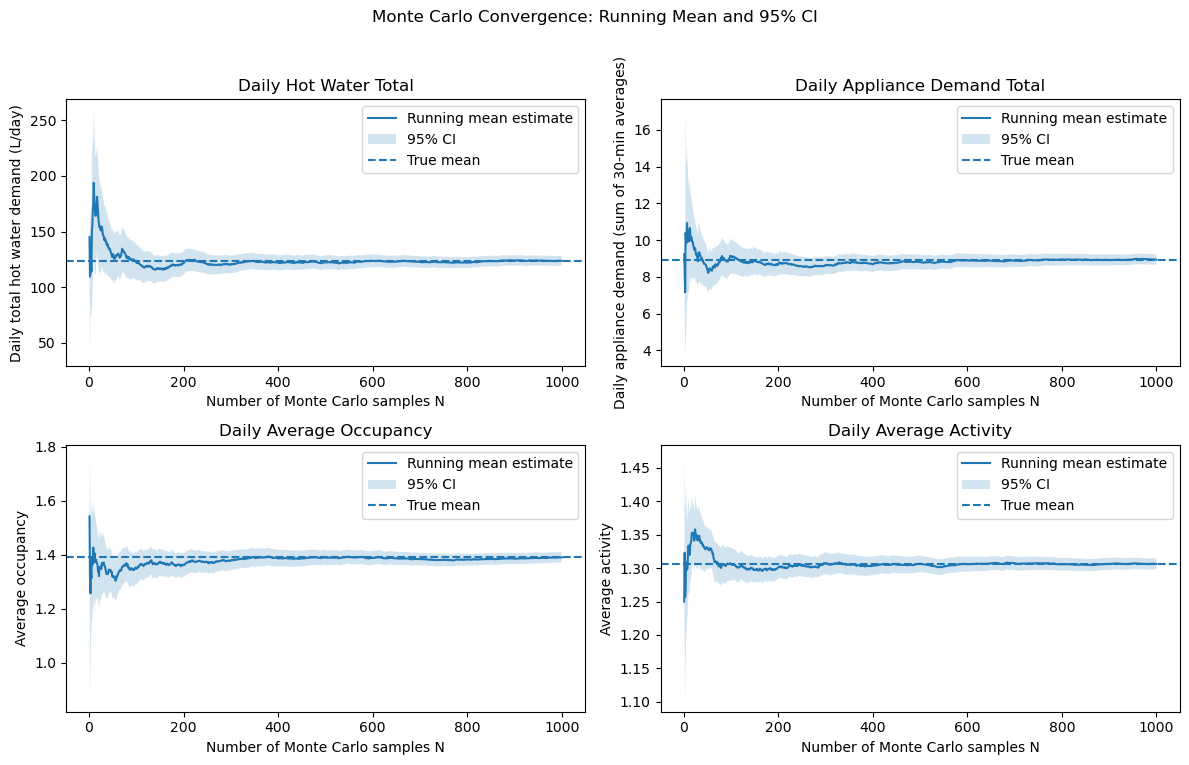

📈 Saved convergence plot to: E:\GitHubProjects\LV network\Input data\Hotwater\crest_wd_2p_urban_30min_convergence.png


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ================== CONFIG ==================
BASE_DIR = Path(
    r"E:\GitHubProjects\LV network\Input data\Hotwater"
)
INPUT_FILE = BASE_DIR / "crest_wd_2p_urban_30min.csv"
N_SAMPLES = 1000
# ============================================


def plot_convergence(ax: plt.Axes, samples: np.ndarray, title: str, ylabel: str) -> None:
    running_mean = np.cumsum(samples) / np.arange(1, len(samples) + 1)
    running_std = np.array(
        [np.std(samples[:i], ddof=1) if i > 1 else 0.0 for i in range(1, len(samples) + 1)]
    )
    ci_half_width = 1.96 * running_std / np.sqrt(np.arange(1, len(samples) + 1))
    true_mean = samples.mean()
    x = np.arange(1, len(samples) + 1)

    ax.plot(x, running_mean, label="Running mean estimate")
    ax.fill_between(
        x,
        running_mean - ci_half_width,
        running_mean + ci_half_width,
        alpha=0.2,
        label="95% CI",
    )
    ax.axhline(true_mean, linestyle="--", label="True mean")
    ax.set_title(title)
    ax.set_xlabel("Number of Monte Carlo samples N")
    ax.set_ylabel(ylabel)
    ax.legend()


df = pd.read_csv(INPUT_FILE, index_col="time", parse_dates=True)

hotwater_cols = [
    f"run_{i}_hotwater_L" for i in range(N_SAMPLES) if f"run_{i}_hotwater_L" in df.columns
]
occupancy_cols = [
    f"run_{i}_occupancy" for i in range(N_SAMPLES) if f"run_{i}_occupancy" in df.columns
]
activity_cols = [
    f"run_{i}_activity" for i in range(N_SAMPLES) if f"run_{i}_activity" in df.columns
]
appliance_cols = [
    f"run_{i}_appliance_demand_W"
    for i in range(N_SAMPLES)
    if f"run_{i}_appliance_demand_W" in df.columns
]

if len(hotwater_cols) < N_SAMPLES:
    raise ValueError("Not enough Monte Carlo hot water columns in the input file")
if len(occupancy_cols) < N_SAMPLES:
    raise ValueError("Not enough Monte Carlo occupancy columns in the input file")
if len(activity_cols) < N_SAMPLES:
    raise ValueError("Not enough Monte Carlo activity columns in the input file")
if len(appliance_cols) < N_SAMPLES:
    raise ValueError("Not enough Monte Carlo appliance demand columns in the input file")

# total daily hot water per run (L/day)
hotwater_totals = df[hotwater_cols].sum(axis=0).to_numpy()

# total daily appliance demand per run (sum of 30-min averages)
appliance_totals = df[appliance_cols].sum(axis=0).to_numpy()

# daily average occupancy/activity per run
occupancy_daily_avg = df[occupancy_cols].mean(axis=0).to_numpy()
activity_daily_avg = df[activity_cols].mean(axis=0).to_numpy()

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False)
axes = axes.flatten()

plot_convergence(
    axes[0],
    hotwater_totals,
    "Daily Hot Water Total",
    "Daily total hot water demand (L/day)",
)
plot_convergence(
    axes[1],
    appliance_totals/2000,
    "Daily Appliance Demand Total",
    "Daily appliance demand (sum of 30-min averages)",
)
plot_convergence(
    axes[2],
    occupancy_daily_avg,
    "Daily Average Occupancy",
    "Average occupancy",
)
plot_convergence(
    axes[3],
    activity_daily_avg,
    "Daily Average Activity",
    "Average activity",
)

fig.suptitle("Monte Carlo Convergence: Running Mean and 95% CI")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

output_path = INPUT_FILE.with_name(f"{INPUT_FILE.stem}_convergence.png")
fig.savefig(output_path, dpi=300)
plt.show()

print(f"📈 Saved convergence plot to: {output_path}")